# [E-17] 난 스케치를 할 테니 너는 채색을 하거라

이번 프로젝트는 이미지 생성 모델로 사용되는 GAN 중에서 조건이 추가된 cGAN에 대해 알아보고 Pix2Pix를 배워보는 것을 목표로 한다.
<hr>

## 데이터 준비

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


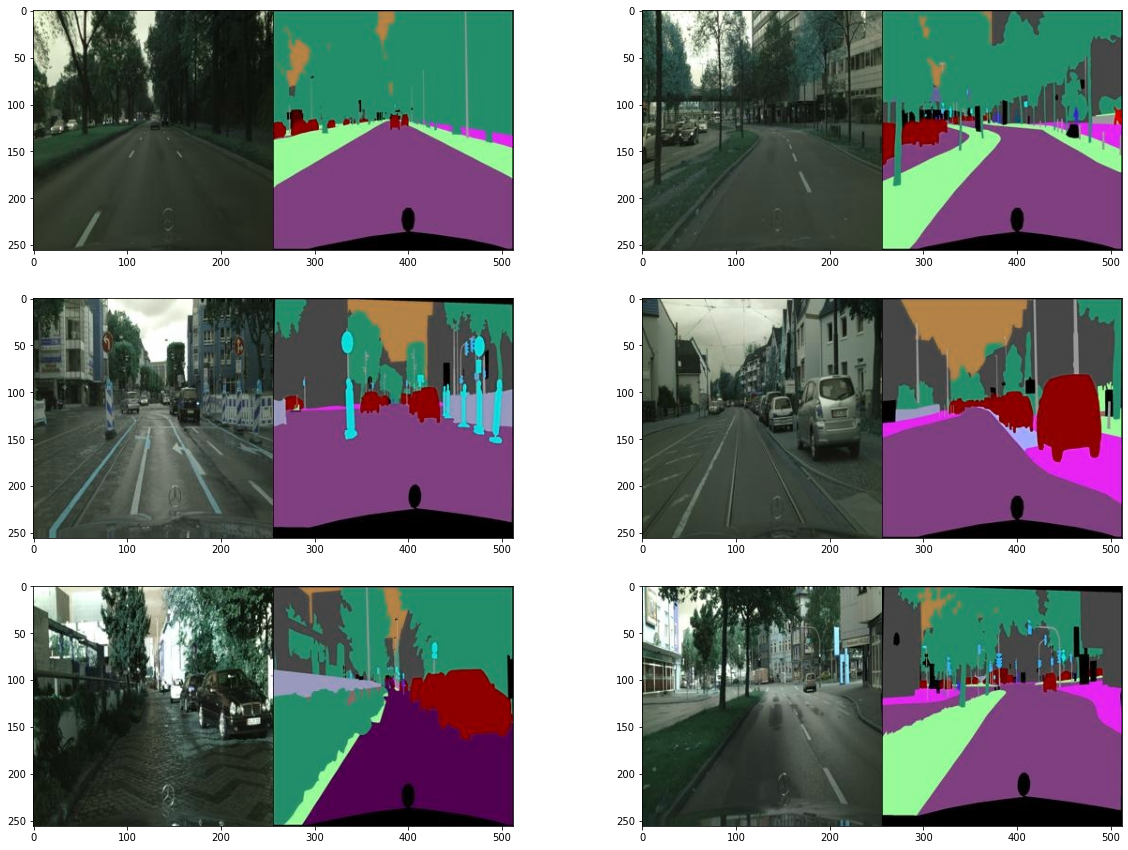

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


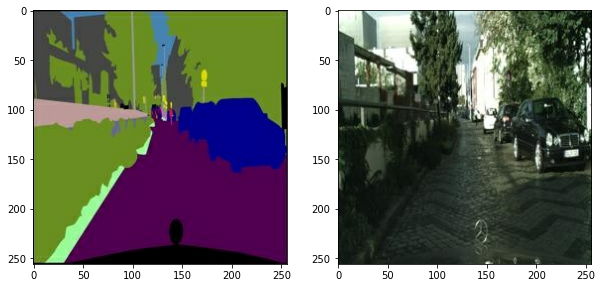

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    input_img = img[:, w:, :] 
    input_img = tf.cast(input_img, tf.float32)
    ground_img = img[:, :w, :] 
    ground_img = tf.cast(ground_img, tf.float32)
    return normalize(input_img), normalize(ground_img)

f = data_path + os.listdir(data_path)[1]
input_img, ground_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_img))
plt.subplot(1,2,2); plt.imshow(denormalize(ground_img))

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(input_img, ground_img):
    stacked = tf.concat([input_img, ground_img], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

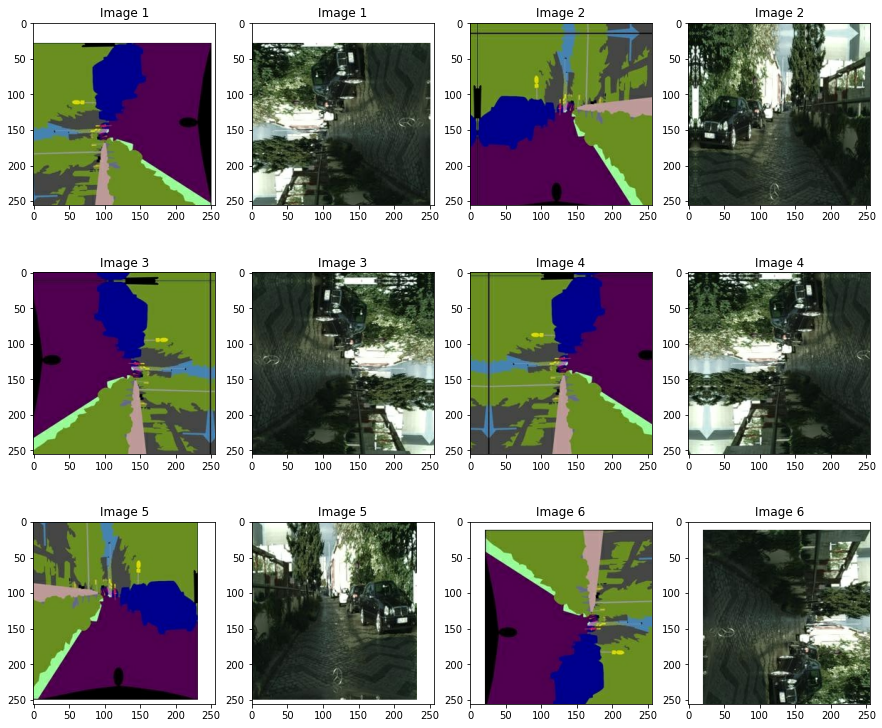

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input_img, augmented_ground_img = apply_augmentation(input_img, ground_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input_img)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_ground_img)); plt.title(f"Image {img_n}")
    img_n += 1

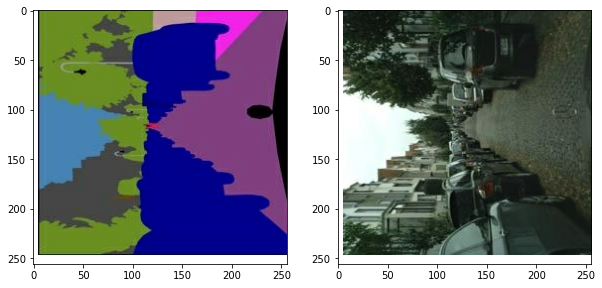

In [7]:
from tensorflow import data

def get_train(img_path):
    input_img, ground_img = load_img(img_path)
    input_img, ground_img = apply_augmentation(input_img, ground_img)
    return input_img, ground_img

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_img, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Generator 재구성

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator 구현

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [13]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 학습 및 테스트

In [14]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [15]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [16]:
@tf.function
def train_step(sketch, ground_img):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_ground_img = generator(input_img, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_img, fake_ground_img, training=True)
        real_disc = discriminator(input_img, ground_img, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_ground_img, ground_img, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [17]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (input_img, ground_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_img, ground_img)
                
        # 100회 반복마다 손실을 출력
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:3.7514                     
L1_loss:0.2689                     
Discriminator_loss:0.0897

EPOCH[1] - STEP[200]                     
Generator_loss:2.4243                     
L1_loss:0.3224                     
Discriminator_loss:0.3679

EPOCH[2] - STEP[100]                     
Generator_loss:2.5468                     
L1_loss:0.3836                     
Discriminator_loss:0.1189

EPOCH[2] - STEP[200]                     
Generator_loss:2.7561                     
L1_loss:0.2758                     
Discriminator_loss:0.3250

EPOCH[3] - STEP[100]                     
Generator_loss:0.6016                     
L1_loss:0.3313                     
Discriminator_loss:1.3549

EPOCH[3] - STEP[200]                     
Generator_loss:0.8623                     
L1_loss:0.3321                     
Discriminator_loss:1.2284

EPOCH[4] - STEP[100]                     
Generator_loss:3.5109                     
L1_loss:0.3298             

EPOCH[29] - STEP[100]                     
Generator_loss:3.6986                     
L1_loss:0.3765                     
Discriminator_loss:0.0383

EPOCH[29] - STEP[200]                     
Generator_loss:2.6560                     
L1_loss:0.4119                     
Discriminator_loss:0.0989

EPOCH[30] - STEP[100]                     
Generator_loss:2.9828                     
L1_loss:0.3846                     
Discriminator_loss:0.1366

EPOCH[30] - STEP[200]                     
Generator_loss:2.9499                     
L1_loss:0.3757                     
Discriminator_loss:0.2369

EPOCH[31] - STEP[100]                     
Generator_loss:2.1983                     
L1_loss:0.4169                     
Discriminator_loss:0.1496

EPOCH[31] - STEP[200]                     
Generator_loss:1.0055                     
L1_loss:0.3644                     
Discriminator_loss:0.7806

EPOCH[32] - STEP[100]                     
Generator_loss:2.6859                     
L1_loss:0.3997      

EPOCH[56] - STEP[200]                     
Generator_loss:3.5032                     
L1_loss:0.3636                     
Discriminator_loss:0.0398

EPOCH[57] - STEP[100]                     
Generator_loss:1.5911                     
L1_loss:0.3927                     
Discriminator_loss:0.4071

EPOCH[57] - STEP[200]                     
Generator_loss:2.7646                     
L1_loss:0.3127                     
Discriminator_loss:0.5517

EPOCH[58] - STEP[100]                     
Generator_loss:3.5207                     
L1_loss:0.3636                     
Discriminator_loss:0.4076

EPOCH[58] - STEP[200]                     
Generator_loss:1.1686                     
L1_loss:0.3327                     
Discriminator_loss:0.7376

EPOCH[59] - STEP[100]                     
Generator_loss:2.7209                     
L1_loss:0.3684                     
Discriminator_loss:0.0883

EPOCH[59] - STEP[200]                     
Generator_loss:2.6465                     
L1_loss:0.3580      

EPOCH[84] - STEP[100]                     
Generator_loss:0.7904                     
L1_loss:0.3389                     
Discriminator_loss:0.7088

EPOCH[84] - STEP[200]                     
Generator_loss:2.3659                     
L1_loss:0.3974                     
Discriminator_loss:0.1217

EPOCH[85] - STEP[100]                     
Generator_loss:2.7041                     
L1_loss:0.3497                     
Discriminator_loss:0.0973

EPOCH[85] - STEP[200]                     
Generator_loss:3.5276                     
L1_loss:0.3310                     
Discriminator_loss:0.0548

EPOCH[86] - STEP[100]                     
Generator_loss:1.0100                     
L1_loss:0.3471                     
Discriminator_loss:0.5683

EPOCH[86] - STEP[200]                     
Generator_loss:2.6934                     
L1_loss:0.3838                     
Discriminator_loss:0.0954

EPOCH[87] - STEP[100]                     
Generator_loss:4.2396                     
L1_loss:0.3664      

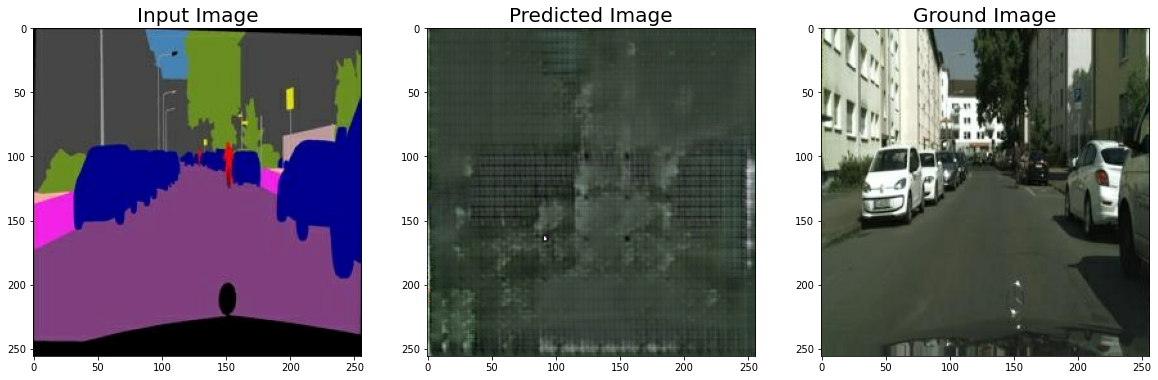

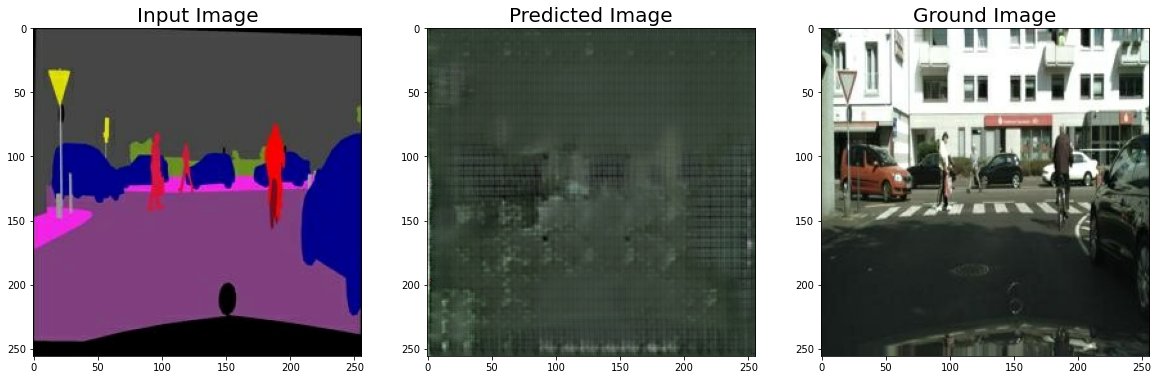

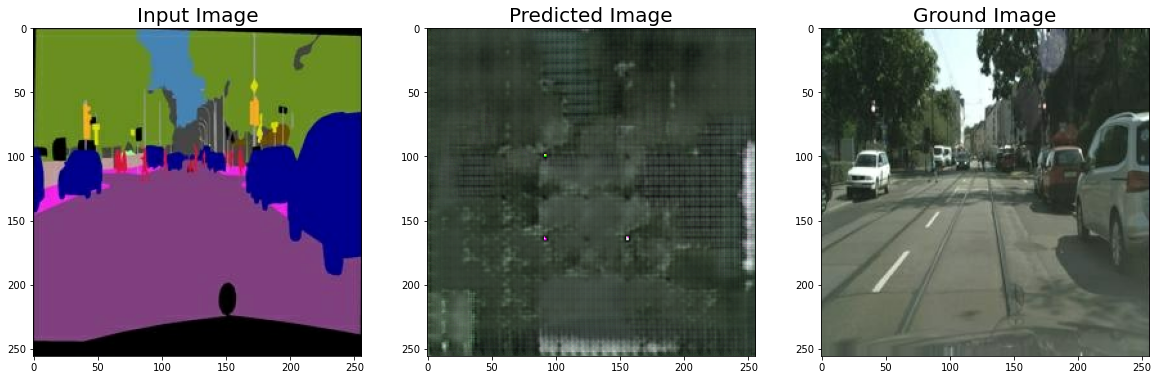

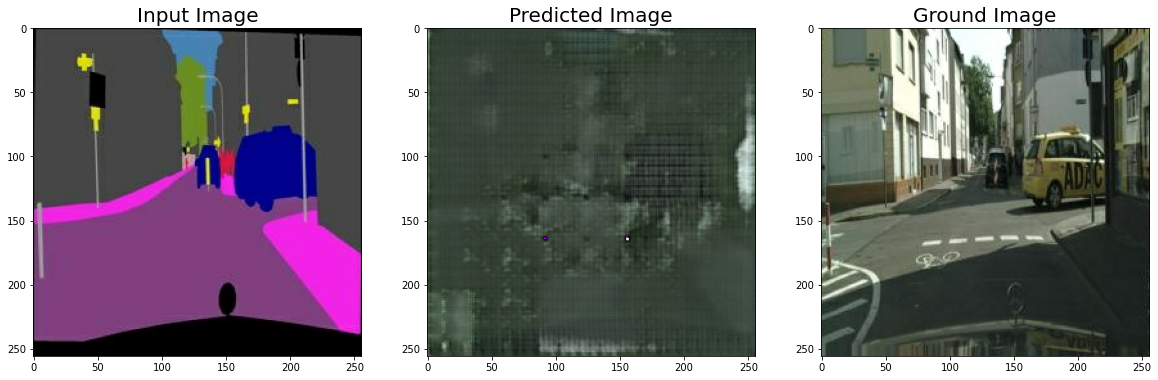

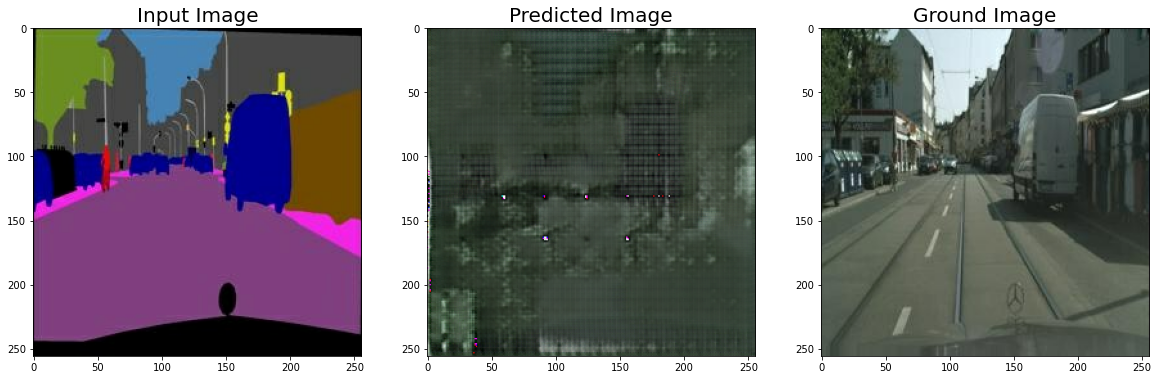

In [18]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'

for test_ind in range(5):
    f = test_path + os.listdir(test_path)[test_ind]
    input_img, ground_img = load_img(f)

    pred = generator(tf.expand_dims(input_img, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_img))
    plt.title('Input Image', fontsize=20)
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(ground_img))
    plt.title('Ground Image', fontsize=20)

## 프로젝트를 마치며

이번 프로젝트에서는 GAN에 조건이 추가된 cGAN과 Pix2Pix를 구현해보았다. 에포크를 300으로 두고 학습을 시켰지만 결과물이 이상하게 나와 확인해보니 input 이미지를 잘못 설정해두었다. 다시 수정하여 진행해보아도 이상한 결과물이 나왔다. 결국 원인은 찾지 못했다. Generator를 생성하는 과정에서 문제가 있었던 것 같은데 조금 더 시간을 두고 고민을 해봐야겠다.